# Préparation

In [ ]:
!pip install gdown==v4.6.3
!pip install eli5
!pip install --upgrade spacy
import gdown
import os
# Google Drive URL for the .txt file
gdrive_cc = "https://drive.google.com/uc?id=1QGtE_ZFFEmzNxtvI5YlrqaOEflnaVvCx"
gdrive_cass = "https://drive.google.com/uc?id=10Z0PTGm8QoHMbCEp4YEBCYteaRm_3Gs_"

# Download the .txt file into the target directory
gdown.download(gdrive_cc, "CC.csv", quiet=False)
gdown.download(gdrive_cass, "CassTexts.csv", quiet=False)

In [2]:
!python -m spacy download fr_core_news_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 MB 5.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# Prelude: Scraping CassTexts

In [ ]:
import requests
import spacy
import regex as re
from bs4 import BeautifulSoup
from collections import defaultdict
import pandas as pd

url = "https://www.courdecassation.fr/recherche-judilibre?sort=date-desc&items_per_page=30&search_api_fulltext=&expression_exacte=&date_du=2016-12-01&date_au=2022-10-17&judilibre_chambre=&judilibre_type=&judilibre_publication=&judilibre_solution=&judilibre_juridiction=cc&judilibre_formation=&judilibre_zonage=&judilibre_doctype=&judilibre_siege_ca=&judilibre_nature_du_contentieux=&judilibre_type_ca=&op=Trier&page="
nlp = spacy.load('fr_core_news_md', disable=["tok2vec", "tagger", "parser", "attribute_ruler", "ner", "textcat"])

main_list = []  # We create a main list, in which we will fit all our sublists, each of which represent a decision. From this list of list, we will later create a dataframe: each sublist will be a row corresponding to a decision
dds = []  # a container for the defaultdicts from the decisions (see below)
types = [] # keeping track of all categories of text in the database (see below)
for x in range(1, 20):
    print(x)
    webpage = requests.get(url + str(x)) # As always, we connect on the page that lists the urls of the decisions, page by page
    soup = BeautifulSoup(webpage.content)  # We get the html of that page
    aas = soup.find_all("div", class_="decision-item")  # And we find the elements representing these decisions themselves
    for a in aas:  # We start a second loop, going now decision by decision, using the elements we just found
        href = a.find("a").get("href")  # Each of that element, in the attribute href, has the url to the decision itself
        sublist = [href]  # Looping through that list, we create a sublist in which we add info about each case, starting with the url
        title = a.find("h3").text.split("-\n")  # We split the element to obtain the relevant subelements in the title
        formation = a.find("p", class_="decision-item-header--secondary").text.split("-")[0]
        solution = a.find("p", class_="decision-item-header--secondary solution").text
        for x in title + [formation, solution]:   # And we add all this to our sublist
            sublist.append(x.strip())

        webpage = requests.get("https://www.courdecassation.fr" + href)  # Now we connect to the decision page itself, to get the data
        # that is not accessible straight from the decision element on the main page
        soup = BeautifulSoup(webpage.content)
        text = soup.find("div", class_="decision-content decision-content--main").getText()  # To fetch the text of the decision
        peuple = re.search("AU NOM DU PEUPLE", text)  # Cutting if text is too long, and we prefer to cut the entête rather than the text
        sublist.append(text[peuple.start():6000]) if peuple is not None else sublist.append(text[:5000])  # A 5000 max length is legit
        main_list.append(sublist)  # Adding to main_list, which is thus a list of lists, with each sublist corresponding to a case

        dd = defaultdict(str)  # We create a defaultdict to make sure that new entries will be an empty string
        current_type = "" # variable to keep track of the header
        for el in soup.find_all(["h3", "p"]):
            if el.name == "h3" and el.find("button") is not None:
                current_type = el.find("button").getText().strip()
                if current_type not in types:
                    types.append(current_type)
            elif el.name == "p" and "id" in el.attrs:  # We make sure this is a "p" element, as some h3 elements without button subels should not be taken into account
                dd[current_type] += el.getText().strip() + "\n-----\n"
        dds.append(dd)

for e, d in enumerate(dds):  # Based on the defaultdicts collected above, we can add to the existing sublists by adding the relevant values
    for tt in types:
        data = d[tt]
        main_list[e].append(data[:5000])

cassdf = pd.DataFrame(main_list, columns=["URL", "Date", "Cour", "ID", "Formation", "Solution", "Text"] + types)  # Once this is done, we create our dataframe
cassdf.to_csv("Cassdf.csv", encoding="utf8")

In [ ]:
cassdf

# Principles of Machine Learning

Machine learning equips us with the tools to teach machines how to learn from data and make decisions, much like a human would, albeit in a confined scope. When it comes to text data, machine learning offers a panoply of techniques that render the ineffable, effable; it turns the complexity of human language into something machines can understand.

<b>1. </b> The primary hurdle in dealing with text data is that it's essentially unquantifiable in its raw form. Words, unlike numbers, carry meaning that is nuanced and contextual. This is where the notion of **commensurability** comes into play. In simple terms, commensurability refers to the process of making things comparable. In the context of text and machine learning, this means transforming human language into mathematical expressions that a computer can easily manipulate.

Python offers various libraries like `sklearn` and `nltk` that handle these transformations elegantly. Functions such as `CountVectorizer` or `TfidfVectorizer` reduce textual information into vectors of numbers, often in a format known as a sparse matrix. Each word, or sometimes a sequence of words, becomes a coordinate in a high-dimensional space. Consequently, we can then perform mathematical operations on these vectors to derive meaningful insights or make predictions.

<b>2. </b> Once our text data is transformed into a quantifiable form, we can feed it into a machine learning algorithm. Algorithms act as a sort of instructor for the machine, teaching it how to respond to new, unseen data based on the patterns it observed in the training data. Popular algorithms used in text data analysis include Naive Bayes, Support Vector Machines (SVM), and Neural Networks.

When applying machine learning to text data, one usually employs one of two paradigms: supervised learning or unsupervised learning.

1.   *Supervised Learning*: In this scenario, the algorithm learns from a labeled dataset, and makes predictions or decisions without human intervention. Imagine you have a large set of emails that are categorized as either 'Spam' or 'Not Spam.' A supervised learning algorithm could learn the characteristics of spam emails and automatically classify new emails accordingly.
2.   *Unsupervised Learning*: This involves training the machine on an unlabeled dataset and allowing it to identify patterns and relationships therein. For instance, you could have a large collection of news articles, and an unsupervised algorithm could automatically group these articles into different topics without being explicitly told how to do so.

One of the main issues in machine learning is known as **overfitting**, where a machine learning model performs exceedingly well on the data it is trained on but fails to generalize to new, unseen data.

In overfitting, the model captures the noise in the training data, mistaking it for a pattern. This can happen when a model is too complex relative to the simplicity of the problem.

Here's an example using Python and Scikit-learn to illustrate overfitting with a polynomial regression model:

Training Score: 0.8101782962050819
Test Score: 0.46010296180954857


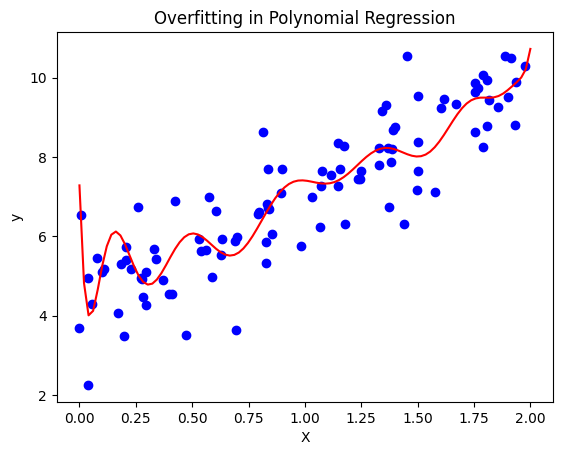

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Generating synthetic data
np.random.seed(1)
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Polynomial Features
poly = PolynomialFeatures(degree=15)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Training model
model = LinearRegression()
model.fit(X_train_poly, y_train)

# Scoring
train_score = model.score(X_train_poly, y_train)
test_score = model.score(X_test_poly, y_test)

print(f"Training Score: {train_score}")  # Very high, indicating excellent fit
print(f"Test Score: {test_score}")  # Significantly less than training score, indicating poor generalization

# Plotting
X_range = np.linspace(0, 2, 100).reshape(-1, 1)
X_range_poly = poly.transform(X_range)
y_range = model.predict(X_range_poly)

plt.scatter(X, y, color='blue')
plt.plot(X_range, y_range, color='red')
plt.title("Overfitting in Polynomial Regression")
plt.xlabel("X")
plt.ylabel("y")
plt.show()

# Natural Language Processing

<b>1. </b>Natural language processing (NLP) refers to a set of methods and tools used to work with text data.

The field is based on the fact that language, as you might have noted, is not random: we use different words in frequencies that are meaningful, and in accordance with a syntax that makes these words obey a number of rules.

For instance, <a href="https://en.wikipedia.org/wiki/Zipf%27s_law">Zipf's Law</a> is seemingly true, so far, of every natural language; once you know this, you can, e.g., identify words that depart from the average, for instance to identify topics, or even forgeries (e.g., like tax authorities - in theory - make use of <a href="https://en.wikipedia. org/wiki/Benford%27s_law">Benford's Law</a> to track fraud).

Now, one of the fields's basic ideas is that words and concepts can be reduced to vectors, which then allow them to be compared with each other - but also to find similarities. (In this respect, I recommend
this <a href="https://www.newyorker.com/magazine/2021/12/06/the-science-of-mind-reading">New Yorker article</a> which explains the greater picture here, as the same intuition powers attempts to read the brain of paralysed individuals, for instance).


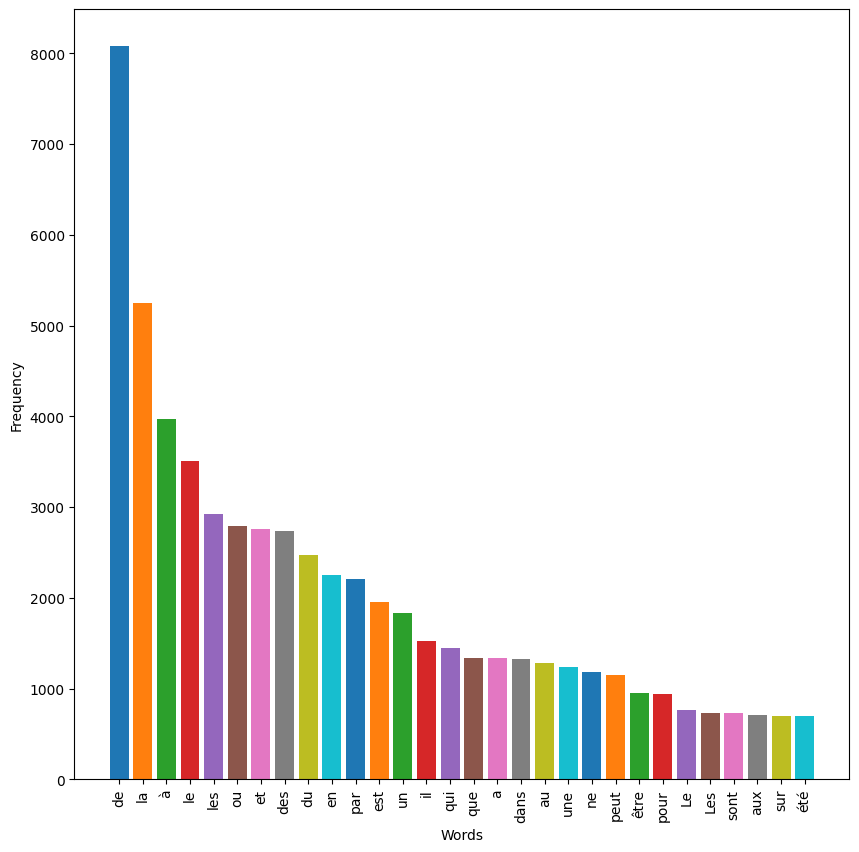

In [ ]:
import pandas as pd
import regex as re
import spacy
from collections import Counter
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


nlp = spacy.load("fr_core_news_md", disable=["ner", "textcat"])  # We download spacy in a nlp object; the disable function is for efficiency purposes
# (some bits of Spacy are slow and useless for our purposes). Models need to be downloaded from the terminal

df = pd.read_csv("CC.csv", header="infer")  # Working with a dataset of versions of the Code civil since 1804

text = "\n".join(df.loc[df.version == 1]["Text"].values.tolist())
doc = nlp(text)
words_doc = [tok.text for tok in doc if tok.is_alpha and not tok.is_punct]
CW = Counter(words_doc)
plt.figure(figsize=(10,10))  #to increase the plot resolution
plt.ylabel("Frequency")
plt.xlabel("Words")
plt.xticks(rotation=90)    #to rotate x-axis values
for word , freq in CW.most_common(30):
    plt.bar(word, freq)
plt.show()

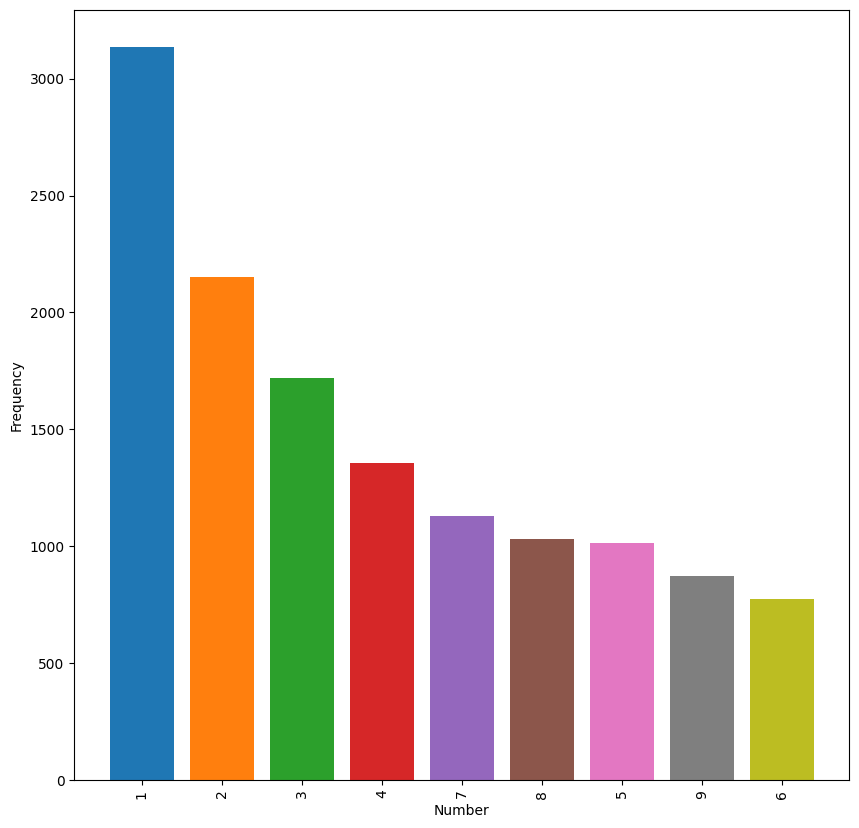

In [ ]:
# Now Benford's law

numbers = re.findall("[1-9](?=\d|\-|$)", "".join(df.Art.values.tolist()))
CC = Counter(numbers)
plt.figure(figsize=(10,10))  #to increase the plot resolution
plt.ylabel("Frequency")
plt.xlabel("Number")
plt.xticks(rotation=90)    #to rotate x-axis values

for key, value in CC.most_common(9):
    plt.bar(key, value)
plt.show()

<b>2. </b> Don't worry, you don't need to go deep into the mathematics of it all to use NLP, however. As often with
Python, someone has already done most of the work for you.

That includes actually preparing datasets and ways to analyse text that cuts to the chase. As mentioned, language
follow some rules, but that leaves quite a lot of variety, and you wouldn't go very far if your script thinks that
two versions of the same conjugated verb represent totally different words. Words are also polysemic, and you need
Python to understand that a "fly" is different from the verb "to fly". Also, how do you recognise words that are not
in a standard dictionary, or even names ?

<b>3. </b> All this is why tools in this space typically attempt to provide the following functions:

<ul><li><b>Tokenizer</b> We want to reduce words to tokens with a fixed meaning; this often involves</li>
<ol><i>stemmization</i>, the process of finding the "root" of a word that gets inflected; and</ol>
<ol><i>lemmatisation</i>, the process of attaching words that go together to a single lemma (this is harder and
requires pre-existing data); and</ol>
<ol><i>stop-words</i> often need to be removed: these are the "the", "and", punctuations, etc., that in most cases
are not meaningful for the analysis (though could be for some: for instance, stylometry).</ol>
    <li><b>Part of Speech (POS) tagging</b>, i.e., identifying subjects, verbs, etc.</li>
    <li><b>Chunking</b>, to identify parts of a text that necessarily go together, like verbs with split
auxiliaries; or names like "Professeur Barbotin"</li>
    <li><b>Named Entities Recognition</b>, to distinguish names from the rest of a text, but also to assign a value
to these names (organisation, proper name, brand, etc.).</li>
    </ul>

<b>4. </b>In what follows, we'll use the module `spacy`, which does all that, including for French. (A more legacy,
yet good alternative is `nltk`, which has modules specific to French as well). Go <a href="https://spacy. io/usage">here</a> to check how to import spacy and the language model.

Spacy processes documents and texts according to a pipeline: first finding the tokens, then their roots, then their place in a sentence, etc.
![](../Data/Images/spacypipeline.png)

We'll do it over a dataset of articles from the Code civil to check who were the main subjects of the law at the time, and who are they now.

<b>5. </b>But first a few words as to `spacy`: you first need to load the language module in an object (here called nlp), and from that object you use functions related to a text. The main function is to transform some text in a token or a list of tokens.

The reason why we use already-collected language models is that they are already "smart": they know what words refer
to in general (though maybe not in the context of a subdomain, such as law). Usually, this is done by ingesting
loads of text, and identifying words that go together, to get a sense of the distance between two words: if two
distinct words are often used interchangeable in a given context, they are probably synonyms, for instance. Doing
this you obtain vectors that gives you an approximation of a word's position in the vocabulary space. (This is
called word-embedding, and you can lear more about it <a href="https://www.analyticsvidhya.com/blog/2020/08/top-4-sentence-embedding-techniques-using-python/">here</a>, or <a href="https://penseeartificielle.fr/methode-google-comprendre-sens-mots-word-embedding-python-gensim/">here</a>)

But here is the most common example: using the word "roi", we can try to identify what's the closest approximation
of "roi" once we substract "homme" and add "femme" (works only with larger French model).

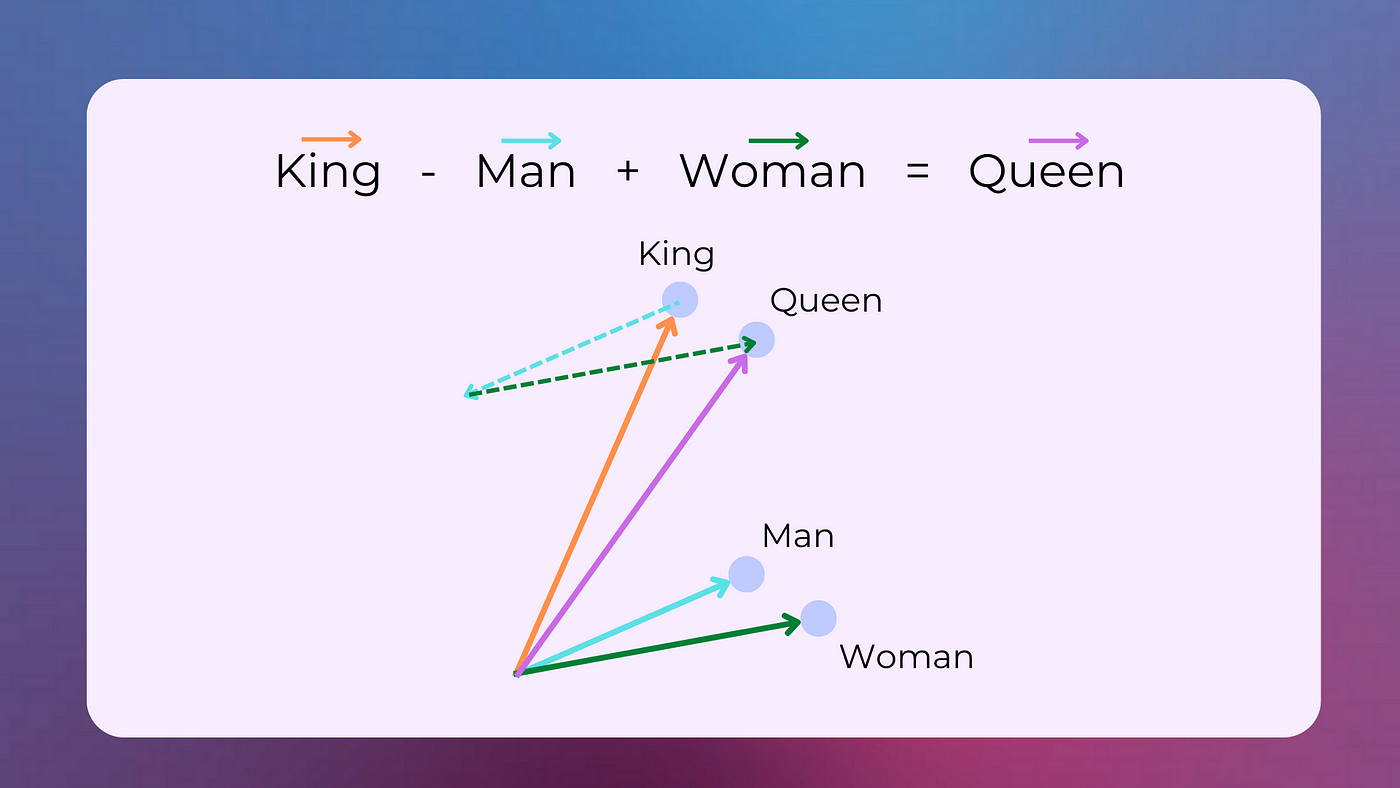

In [ ]:
# And now in French

roi = nlp("roi")

def close_words_from_vector(vec):  # A function that returns the 10 most similar words compared to "vec"
    ms = nlp.vocab.vectors.most_similar(np.array([vec]), n=10)
    return [nlp.vocab.strings[w] for w in ms[0][0]]

print(close_words_from_vector(roi.vector))

analogie = nlp("roi").vector - nlp("homme").vector + nlp("femme").vector  # We find the vector that corresponds to roi, minus homme, plus femme
print(close_words_from_vector(analogie))  # Works only with large model

['Sigtrygg', 'Ballithar', 'vice-prince', 'Énarque', 'Curopalate', 'ereur', 'виде', 'Khorat', 'E-81', 'Piédestal']
['Sigtrygg', 'vice-reine', 'Ballithar', 'vice-prince', 'виде', 'Sveltesse', 'Énarque', 'Curopalate', 'L-1219', 'Piédestal']


<b>6. </b> Vectors (and similarities) are fun, but mostly you'll be interested in spacy's power
to detect what's a subject, a stop word, etc. A few attributes found in spacy tokens are essential here:
<ul><li><b>pos_</b>Which is the part of speech (think verb, nouns, etc.)</li>
<li><b>dep_</b>, which is the relation of a given word with the structure of a sentence, to distinguish a subject
from an object, by instance; and</li>
<li><b>morph</b> Which gives you a number of additional data point about a token, such as gender, number, and
conjugation; and</li>
    </ul>

Besides, spacy has a number of booleans inserted into tokens, which you can query with attributes such as `.
is_punct` (True if punctuation, False otherwise), `is_stop` (True if stop word, False otherwise), etc.

In [ ]:
article_1382 = "Tout fait quelconque de l'homme, qui cause à autrui un dommage, oblige celui par la faute duquel il est arrivé à le réparer."
article_1383 = "On est responsable non seulement du dommage que l'on cause par son propre fait, mais encore de celui qui est causé par le fait des personnes dont on doit répondre, ou des choses que l'on a sous sa garde. Toutefois, celui qui détient, à un titre quelconque, tout ou partie de l'immeuble ou des biens mobiliers dans lesquels un incendie a pris naissance ne sera responsable, vis-à-vis des tiers, des dommages causés par cet incendie que s'il est prouvé qu'il doit être attribué à sa faute ou à la faute des personnes dont il est responsable. Cette disposition ne s'applique pas aux rapports entre propriétaires et locataires, qui demeurent régis par les articles 1733 et 1734 du code civil. Le père et la mère, en tant qu'ils exercent l'autorité parentale, sont solidairement responsables du dommage causé par leurs enfants mineurs habitant avec eux. Les maîtres et les commettants, du dommage causé par leurs domestiques et préposés dans les fonctions auxquelles ils les ont employés ; Les instituteurs et les artisans, du dommage causé par leurs élèves et apprentis pendant le temps qu'ils sont sous leur surveillance. La responsabilité ci-dessus a lieu, à moins que les père et mère et les artisans ne prouvent qu'ils n'ont pu empêcher le fait qui donne lieu à cette responsabilité.En ce qui concerne les instituteurs, les fautes, imprudences ou négligences invoquées contre eux comme ayant causé le fait dommageable, devront être prouvées, conformément au droit commun, par le demandeur, à l'instance."

doc = nlp(article_1382)  # We transform the text in a spacy object
for tok in doc:  # Iterating through each token in the text
    if tok.is_stop is False and tok.is_punct is False:  # We check that the token is not a "stop word", and is not pure punctuation
        print(tok, tok.lemma_, tok.dep_, tok.pos_)  # In that case, we print the token text, its lemma, its place in text, etc
    else:
        print(tok.text)  # Otherwise we just print the text


doc2 = nlp(article_1383)  # This article has several sentences, so we can use Spacy to split them; each sentence become a full list of tokens, but keeps attributes from full text (like when does it start)
for sent in doc2.sents:
    print(sent, sent.start)  # We print each sentence
    verbs = []
    for tok in sent:  # For each sentence, we go token by token
        if tok.pos_ == "VERB":  # We check if that token is a subject, and then we print it
            verbs.append(tok.text + "=" + tok.lemma_)
    print("VERBS: ", verbs)

    nouns = []
    for chunk in sent.noun_chunks:  # We print the groupe nominaux
        nouns.append(chunk)
    print("NAME GROUPS: ", nouns)

Tout
fait
quelconque
de
l'
homme homme nmod NOUN
,
qui
cause cause acl:relcl VERB
à
autrui
un
dommage dommage obj NOUN
,
oblige obliger advcl VERB
celui
par
la
faute faute obl:agent NOUN
duquel
il
est
arrivé arriver ROOT VERB
à
le
réparer réparer obl:arg VERB
.
On est responsable non seulement du dommage que l'on cause par son propre fait, mais encore de celui qui est causé par le fait des personnes dont on doit répondre, ou des choses que l'on a sous sa garde. 0
VERBS:  ['cause=cause', 'causé=causer', 'doit=devoir', 'répondre=répondre', 'a=avoir']
NAME GROUPS:  [On, dommage, l', on, son propre fait, encore de celui, qui, le fait, des personnes, on, que, l', on, sa garde]
Toutefois, celui qui détient, à un titre quelconque, tout ou partie de l'immeuble ou des biens mobiliers dans lesquels un incendie a pris naissance ne sera responsable, vis-à-vis des tiers, des dommages causés par cet incendie que s'il est prouvé qu'il doit être attribué à sa faute ou à la faute des personnes dont il 

<b>7. </b>Another thing we can do is to curate the text, then look at the most common words, depending on the year of the
version of the code civil.

<u>Exercise</u> Based on what you just learned, find the 15 most common subjects in the Code civil for each year
between 1980 and 2020.

In [ ]:
df.index = pd.to_datetime(df.Date)  # Change the index to the date of the article, so as to do time series

def spacy_process(text):  # We first prepare the text by using spacy's token elements to remove stop words and punctuation
    doc = nlp(text)   # We transform the text with spacy
    filtered_sentence = []   # Empty list for the tokens we'll want to keep
    punctuations = ["?",":","!",".",",",";","-", "(",")"]  # A list of punctuation
    banned_words = ["ARTICLE", "CODE"]  # A list of words we are not interested in, because they are very frequent
    for token in doc:
        if token.is_stop is False and token.lemma_ not in punctuations and token.text.upper() not in banned_words:  # We append tokens to the list only if they are not a stop word or in our list of punctuations
            filtered_sentence.append(token.lemma_)

    return " ".join(filtered_sentence)


df["CText"] = df.Text.map(lambda x: spacy_process(x))  # We apply it to our dataframe, so as to have a new column with cleaned text, rid of stop words and punctuations


def get_code_by_date(db, end):  # The idea is to sort by version (higher number > newer text) as the dictionary will take the last result
    data = []
    tempdict = db[:end].set_index("Art").sort_values(by="version", ascending=True).to_dict()["version"]
    for index, row in db[:end].iterrows():
        if row.Art in tempdict and row["version"] == tempdict[row["Art"]]:
            data.append(row.values)
    return pd.DataFrame(data, columns=db.columns)

1805
1950
2000
2021


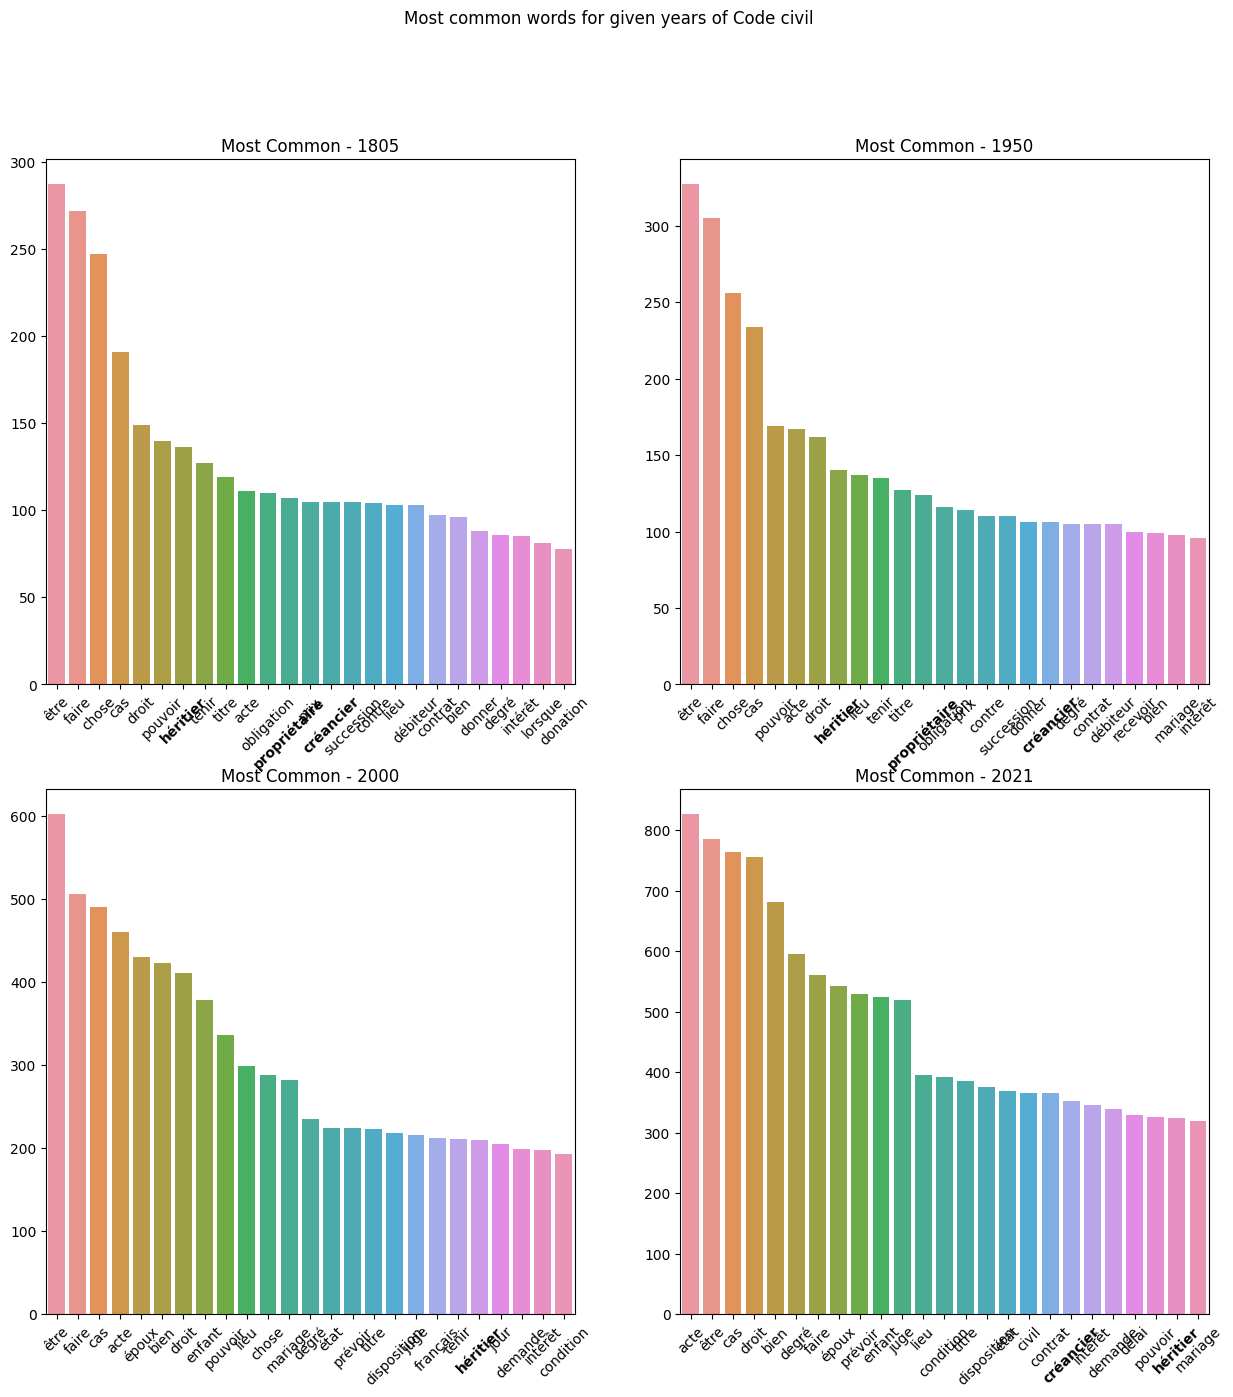

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,15))  # We initialise a set of subplots
fig.suptitle('Most common words for given years of Code civil')  # Which we entitle
for e, year in enumerate(["1805", "1950", "2000", "2021"]):  # A selection of years
    print(year)
    ax.ravel()[e].set_title("Most Common - " + year)
    aggregate_counter = Counter()  # We initialise a counter object (which counts stuff and allows you to get the most common items
    db = get_code_by_date(df, year)  # We get our limited code civil updated by date
    for index, row in db.iterrows():   # We iterate over every article
        c = Counter(row['CText'].split())   # Split into words, and count them
        aggregate_counter += c  # And then them to the main counter

    common_words = []
    common_words_counts = []
    for el in aggregate_counter.most_common(25):  # For the 25 most common items in our counter, we print the name of the item (at index 0), and the count (at index 1)
        #print(el[0], el[1])
        common_words.append(el[0])  # We also add this data to lists that will be used to create a plot
        common_words_counts.append(el[1])

    bar_plt = sns.barplot(ax=ax.ravel()[e], x = common_words, y = common_words_counts)  # We then create a bar plot with seaborn, this takes two inputs: the names of the words, and a count

    for item in bar_plt.get_xticklabels():
        item.set_rotation(45)
        if item._text in ["héritier", "créancier", "propriétaire"] :
            item.set_fontweight("bold")

plt.show()

In [ ]:
# And now for something more complicated...


def get_sents(db):  # First we cut articles in sentences. Note that this could also be done using NLP, but I don't find the performance better in this case
    data = []
    ii = 0
    prev = ""
    for index, art in db.iterrows():
        sents = re.split(r"\.\n|\. (?=[A-Z])", art.Text)
        for sent in sents:
            ii = ii + 1 if art["ID"] == prev else 0
            l = [art["Code"], art["Art"], art["ID"], art["ID"] + "_" + str(ii), art["Date"], sent + ".", len(sent)]
            data.append(l)
            prev = art["ID"]
    return pd.DataFrame(data, columns=["Code", "Art", "ID", "Al", "origin_date", "Text", "lenText"])


def get_subj(doc):
    pastsub = ""
    real_subj = "NoSubj"  # We initialise a variable with subject; it will return "NoSubj" if there aren't any subject
    for subj in [x for x in doc if "nsubj" in x.dep_]:  # We iterate through all possible subjects in the sentence
        real_subj = subj
        if subj.pos_ == "PRON":  # If this is a pronoun, however, we say that the pronoum is the previous subject
            real_subj = pastsub
        else:
            pastsub = subj
    if type(real_subj) == spacy.tokens.token.Token:  # Added to provide full noun chunk
        chunks = [x for x in doc.noun_chunks if real_subj in x]
        full_subj = chunks[0] if len(chunks) == 1 else real_subj.lemma_
    else:
        full_subj = ''
    return [real_subj, full_subj]

# Same code as above, but focusing on subjects per sentence thanks to the functions above
fig, ax = plt.subplots(2, 2)
fig.suptitle('Most common subjects for given years of Code civil')
for e, year in enumerate(["1805", "1950", "2000", "2021"]):  # A selection of years
    print(year)
    ax.ravel()[e].set_title("Most Common Subject - " + year)
    aggregate_counter = Counter()  # We initialise a counter object (which counts stuff and allows you to get the most common items
    db = get_code_by_date(df, year)  # We get our limited code civil updated by date
    db = get_sents(db)
    db["Subj"] = ""
    for index, row in db.iterrows():
        doc = nlp(row["Text"])
        db.at[index, "Subj"] = get_subj(doc)[0]
    bar_plt = sns.barplot(ax=ax.ravel()[e], x=db.Subj.astype(str).value_counts()[1:20].index,y=db.Subj.astype(str).value_counts()[1:20].values)  # We then create a bar plot with seaborn, this takes two inputs: the names of the words, and a count
    for item in bar_plt.get_xticklabels():
        item.set_rotation(45)

# Topic Modelling

This, in short, is a subdomain of Natural Language Processing (NLP) that exploits statistical methodologies to find such emergent themes across a corpus of text.

The crux of these methods lies in their ability to represent each document as a mixture of topics and each topic as a combination of words, all the while leaning on the edifice of probability and linear algebra. For instance, in an array of legal texts, topics might revolve around constitutional law, property rights, or jurisprudence; in a corpus of news articles, politics, sports, and economy might be dominant themes.

Topic modelling is widely utilized across numerous fields, serving both practical and conceptual goals. In academia, it has been employed to discover hidden themes in historical archives or scientific publications. In the commercial realm, it powers recommendation engines, sentiment analysis tools, and content categorization systems. In legal circles, it could assist in organizing case law or legislative texts into coherent themes for easier navigation and understanding.

In [ ]:
!pip install bertopic  # Takes some time to load

In [ ]:
from bertopic import BERTopic
import plotly.io as pio

df = pd.read_csv("CassTexts.csv", header="infer", encoding="latin1")
df["CText"] = df.Text.apply(spacy_process)

nlp = spacy.load("fr_core_news_md", disable=["ner", "textcat"])

topic_model = BERTopic(embedding_model=nlp, n_gram_range=(1, 3), min_topic_size=3, nr_topics="auto")  # We set up the topic model
topics, probs = topic_model.fit_transform(df.CText.values.tolist())
topic_model.get_topic_info()  # We visualise the top terms for each topics
df["Topic"] = topics
# df.to_clipboard(index=False, encoding="utf8")

fig = topic_model.visualize_topics()
pio.show(fig)

# Prediction

<b>1. </b> Machine learning prediction is not that hard - at least if you want to get quick results. Customisation
(to your type of data) is what takes time, which sometimes is not worth it. (Sometimes that time would be better
spent acquiring more data, as this is a chief input for most machine learning applications: better data > better model.)

In general, all applications of machine learning aim at finding a function that best maps an input X to an output y.

<b>2. </b>We'll perform a basic machine learning regression over Cour de cassation judgments, and see if, given a
moyen, we are able to predict the result (cassation or rejet).

After executing all the associated code, you'll see that yes: our (very basic, even dumb) application of machine
learning works in predicting cassation judgments. But now is time for a few caveats, such as:

<ul><li><b>Size</b> How big your dataset is is super important, and 2k-odd judgments is not great in that regard;</li>
<li><b>Distribution</b> In front of <i>any</i> phenomenon, this should be your first question: "what is the
distribution". You might discover that surprising things are not so surprising put in context; here, it might be
relevant to our problem that our dataset was already skewed with 67% cassation compared to rejets;</li>
<li><b>Model</b> Different models might lead to different results, sometimes better, sometimes not, and you should
make sure to try a few (see below); and</li><li><b>Generalisation</b> Depending on the method you use, your model could be very
good at predicting on your training dataset, but terrible at new data, which is called overfitting. That happens,
for instance, when your model is incapable of ignoring noise or outliers.</li></ul>

There are ways to deal with all these aspects. Size would require you to acquire more data (and computing power),
which is not that hard. Distribution can be fixed by using methods to balance a dataset (over- or under-sampling,
adding weights or thresholds). Different models should be tried and compared, and different types of models
(parametric or linear) have different ways of dealing with overfitting.

In [13]:
article_1382 = "Tout fait quelconque de l'homme, qui cause à autrui un dommage, oblige celui par la faute duquel il est arrivé à le réparer."
spacy_process(article_1382)

'homme cause dommage obliger faute arriver réparer'

In [6]:
# 1.  This dataset is scraped in 4d. Topic Modelling
df = pd.read_csv("CassTexts.csv", header="infer", encoding="latin1")  # This is a dataset of decisions from the Cour de cassation involving a "contract" in 2021; there are 818
df = df.loc[df.Solution.isin(["Cassation", "Rejet"])]  # We focus only on the binary classification between Cassation and Rejet
df = df.fillna("")
print(df.columns)

Index(['URL', 'Date', 'Cour', 'ID', 'Formation', 'Solution', 'Text',
       'Motivation', 'Dispositif', 'Entête', 'Moyens annexés',
       'Exposé du litige', 'Moyens', 'CText', 'CTextMotivation'],
      dtype='object')

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from collections import Counter
import pandas as pd
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
import matplotlib.pyplot as plt
import numpy as np

nlp = spacy.load("fr_core_news_md", disable=["ner", "textcat"])  # We download spacy in a nlp object; the disable function is for efficiency purposes

def spacy_process(text):  # See below for explanation as to this function, which we use to clean the texts from stop words and get lemmas
    doc = nlp(text)
    filtered_sentence = []
    punctuations = "?:!.,;()[]\n"
    for token in doc:
        if token.is_stop is False and token.lemma_ not in punctuations:
            filtered_sentence.append(token.lemma_)
    return " ".join(filtered_sentence)

for key in ["Moyens", "Dispositif", "Entête", "Moyens annexés", "Motivation", "Formation"]:
  df["CText" + key] = df[key].apply(spacy_process)  # We clean the moyens with the function used above - It's already done in the dataset you have, but just so you can redo it if necessary

In [18]:
key = "Moyens"
subdf = df[:600].copy()  # We'll work with a subsample, and check the results over the rest of the sample
predict_df = df[600:].copy()  # Which we call predict_df
x = subdf['CText' + key].values  # We collect moyens from the subdf
y = subdf['Solution'].values  # As well as values representing the result
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1000)   # This function splits the sample into a train and test
tfidf = TfidfVectorizer(stop_words=list(fr_stop), ngram_range=(1,3), max_features=250, min_df=10)  # This will be the algorithm to transform the text data in mathematical format, using the tf-idf method we mentioned in Clustering, using a list of French stopwords from Spacy
tfidf.fit(df['CText' + key].values)  # We train that algorithm with the existing data, so that it know what's the weight of any given word ("feature") in the dataset
X_train = tfidf.transform(x_train)  # We then use the trained model to transform our subset of training data
X_test = tfidf.transform(x_test)  # Likewise with testing data
classifier = LogisticRegression()  # This is the method we'll be using, but there are many others ! This one is a basic regression
classifier.fit(X_train, y_train)  # We then feed that model with our training data
score = classifier.score(X_test, y_test)  # And try it over the test data to have a first idea of the accuracy
print("Accuracy:", score)  # Which is not bad !

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['neuf', 'qu', 'quelqu'] not in stop_words.
  warnings.warn(


Accuracy: 0.8466666666666667


In [ ]:
subpredictdf = tfidf.transform(predict_df["CText"])  # Then we test again, a second time, over the rest of the dataset. Likewise, we need to transform this bit of the dataset to mathematical values
val = classifier.predict(subpredictdf)  # We use the .predict function of the classifier to make predictions, this returns a list of labels
predict_df["Predict"] = val.tolist()  # Which we pass to the original dataframe (together with the original solution for the subdf we did not predict)
predict_df["Correct"] = predict_df.apply(lambda x: x["Solution"] == x["Predict"], axis=1)  # We then create a column that tracks done if prediction is equal to reality
print(predict_df.Correct.value_counts(normalize=True))  # And focusing only on those values we predicted, we look for the amount that we got right - this is in line with accuracy score

# We can investigate what chamber is the most easy to predict
print(predict_df.groupby("Formation").Correct.value_counts(normalize=True).unstack())  # We can then compare

# To rebalance the model, we can oversample it - i.e., create fake data that corresponds to the existing one
from imblearn.over_sampling import RandomOverSampler  # This is a module you can dl with "pip install imbalanced-learn"
over_sampler = RandomOverSampler(random_state=42)
X_res, y_res = over_sampler.fit_resample(X_train, y_train)
print(f"Training target statistics: {Counter(y_res)}")
classifier.fit(X_res, y_res)  # We feed the model with this new data
score = classifier.score(X_test, y_test)  # And try it again over the test data to have a first idea of the accuracy
print("Accuracy:", score)

True     0.707993
False    0.292007
Name: Correct, dtype: float64
Correct                                          False     True 
Formation                                                       
Chambre commerciale financière et économique  0.242647  0.757353
Chambre criminelle                            0.481481  0.518519
Chambre sociale                               0.320557  0.679443
Deuxième chambre civile                       0.292969  0.707031
Première chambre civile                       0.255319  0.744681
Première présidence (Ordonnance)                   NaN  1.000000
Troisième chambre civile                      0.313514  0.686486
Training target statistics: Counter({'Cassation': 316, 'Rejet': 316})
Accuracy: 0.78


<b>3. </b>This is why it's important is to investigate what makes a given model perform better.

A first step in this respect is to calculate basic statistical metrics, such as:
<ul>
<li><b>Precision</b> How accurate are your predictions, or how valid are your results, or whether you have a lot
of false positives;</li>
<li><b>Recall</b> How good are you at retrieving signal in your dataset, or how complete are your results, or whether you
have a lot of false negatives;</li>
<li><b>F1 Score</b> For binary systems, is a measure of accuracy over your dataset, based on precision and recall;
closer to 1 is better;</li>
<li><b>Cumulative Gain </b> How does your model performs as opposed to chance.  
</li></ul>

A second step is to evaluate your model over several subsamples of data, with methods such as k-fold (splitting your
dataset in k non-overlapping subsamples) and bootstrapping (creating multiple subsamples from the dataset). The idea
is that, if your model performs well, scores should be relatively stable over the subsamples.

Thirdly, you can investigate your model; one way to do this is to identify the features/vectors that have the most
weight according to the classifier. A module called <code>eli5</code> (for "Explain Like I'm 5") helps in this
respect, outputting the most relevant (i.e., "weighty") features.

Another way is to look at the wrong predictions and try to see what in the dataset.

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold  # We import a cross-validation method

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)  # We initialise the k-fold model, looking for 5 validations
print(cross_val_score(classifier, X_train, y_train, cv=skf, scoring='f1_micro'))

import eli5
data = eli5.show_weights(estimator=classifier, feature_names=list(tfidf.get_feature_names_out()), top=(50,5))
with open("data.html", "w") as file:
    file.write(data.data)

[0.97777778 0.92222222 0.92222222 1.         0.93333333]


<b>4. </b>As noted above, we can try other models and compare their accuracy. Here, I try three distinct methods, all
available from the sklearn package.

<ul>
<li><b>Logistic Regression</b> What we did earlier - this is related to the traditional "linear regression", or the
least-square methods of finding the line that is the closest to the most data points in a scatterplot, though
"logit" is (usually) made for classification purposes. There are plenty of variations, however (the
<code>solver</code> argument in sklearn's classifier), and it is not always fit for purposes;
</li>
<li><b>Trees and Forests</b> On the assumption that features are nodes in a decision tree that links such features
to outputs (our labels), this family of algorithms will randomly tries multiple combinations of features->output
until it finds one or a number of trees (the "Forest") that best predicts new data. The <code>max-depth</code>
argument helps preventing overfitting. A variant of this is the Gradiant Boosting Tree, that goes from tree to tree
trying to explain the errors of the preceding tree;</li>
<li><b>Linear SVC</b> Or "support vector classifier", an algorithm that seeks the largest "gap" in a map with all the
features (given existing labels), so as to assign any data point to one subpart or the map. SVM models are related;</li>
<li><b>Naive Bayes </b> Bayes Theorem is a statistical approach to probability, that links existing probs to
observations in a continuous loop, or, in other words, the probability that A happens knowing that B happened. As
put by a popular blogger: <blockquote>P(A|B) = [P(A)*P(B|A)]/P(B), all the rest is commentary.</blockquote>  Here is <a
href="https://xkcd.com/1132/">a good way to see the difference with the main approach to probabilities</a>.
Naive Bayes approach a dataset with the idea that the features are in fact independent from each others and
contribute equally to the prediction (not true, some words are more important, but helps computationally and returns
good results in general).
Here as well, different flavors of NB, with the GaussianNB assuming a normal distribution of your dataset,
</li></ul>

Finally, it's important to note that some of these models are probabilistic: they keep track of how likely their predictions are.

RandomForestClassifier(max_depth=3, n_estimators=200, random_state=0)
DecisionTreeClassifier(max_depth=3)
LinearSVC()
SVC()
LogisticRegression(random_state=0)
GaussianNB()
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


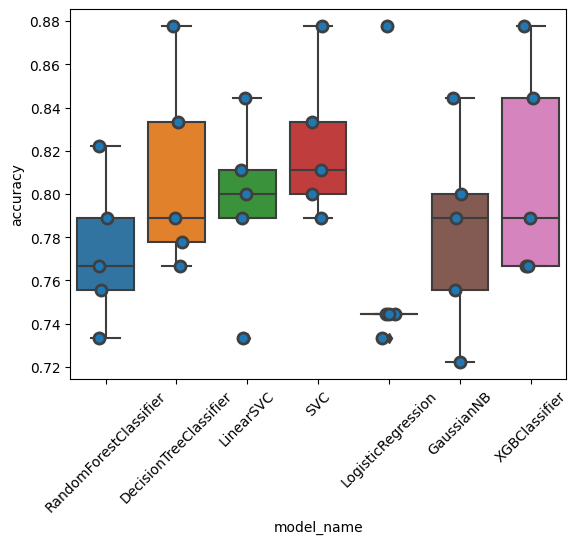

True     0.763458
False    0.236542
Name: Correct, dtype: float64


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

models = [RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0), DecisionTreeClassifier(max_depth=3),
    LinearSVC(), SVC(), LogisticRegression(random_state=0), GaussianNB(), XGBClassifier()]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    print(model)
    model_name = model.__class__.__name__
    if model_name in ["GaussianNB"]:  # Some models require differently formatted data
        accuracies = cross_val_score(model, np.asarray(X_train.todense()), y_train, scoring='accuracy', cv=CV)
    elif model_name in ['XGBClassifier']:  # Some models require differently formatted data
        hot = {"Cassation": 0, "Rejet": 1}
        accuracies = cross_val_score(model, X_train, [hot[x] for x in y_train], scoring='accuracy', cv=CV)
    else:
        accuracies = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.xticks(rotation=45)
plt.show()
# Accuracy score
cv_df.groupby('model_name').accuracy.mean()

# Some models are probabilistic, and we can then use that probability to further fine-tune our results
classifier = SVC(probability=True)  # This is the method we'll be using, but there are many others ! This one is a basic regression
classifier.fit(X_train, y_train)
subpredictdf = tfidf.transform(predict_df["CText"])  # Then we test again, a second time, over the rest of the dataset. Likewise, we need to transform this bit of the dataset to mathematical values
val = classifier.predict(subpredictdf)  # We use the .predict function of the classifier to make predictions, this returns a list of labels
probs = classifier.predict_proba(subpredictdf)
predict_df["Predict"] = val.tolist()  # Which we pass to the original dataframe (together with the original solution for the subdf we did not predict)
predict_df["Prob"] = probs.tolist()
predict_df["Correct"] = predict_df.apply(lambda x: x["Solution"] == x["Predict"], axis=1)  # We then create a column that tracks done if prediction is equal to reality
np.mean([x[0] for x in predict_df.loc[predict_df.Predict=="Cassation"]["Prob"].values.tolist()]) # We check the average probability of getting it right
# predict_df[[key, "Predict", "Prob", "Correct"]].to_clipboard(index=False, encoding="utf8")
print(predict_df.Correct.value_counts(normalize=True))